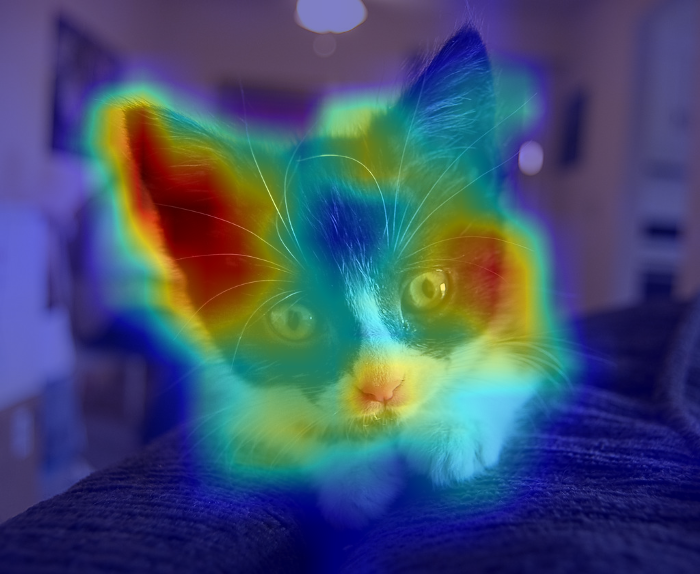

In [8]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import numpy as np
from PIL import Image
import torchvision


model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

path = './data/GradCAM/cat.jpg'
image = np.array(Image.open(path))
image_float_np = np.float32(image) / 255
# define the torchvision image transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Create an input tensor image for your model..
input_tensor = transform(image)
input_tensor = input_tensor.unsqueeze(0)

# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=False)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
targets = [ClassifierOutputTarget(281)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(image/255, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)

In [5]:
g_img = np.asarray(Image.open(path).convert('L'))

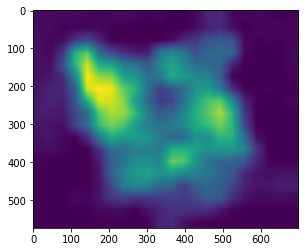

In [6]:
import matplotlib.pyplot as plt 
plt.imshow(grayscale_cam[:])